In [1]:
# === Step 1: Environment & API Initialization ===
# Load environment variables, set up OpenAI API key, and validate critical configurations

import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import logging
from dotenv import load_dotenv
import openai

# --- Configure Logging ---
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# --- Load .env file ---
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

# --- Function to Validate and Set OpenAI API Key ---
def initialize_openai():
    if not api_key:
        raise EnvironmentError("OPENAI_API_KEY not found in .env file.")
    openai.api_key = api_key
    logging.info("OpenAI API key loaded and initialized.")

# --- Call Initialization ---
initialize_openai()

2025-06-05 13:56:54,188 [INFO] OpenAI API key loaded and initialized.


In [3]:
# Step 2: Simulate realistic engagement data for a single day — now wrapped in a function

import numpy as np

def simulate_engagement_data(is_weekend=False, plot=True, verbose=True):
    """
    Simulates Peloton hourly engagement data for a day.
    
    Parameters:
        is_weekend (bool): Whether to simulate weekend behavior
        plot (bool): Whether to display a matplotlib plot
        verbose (bool): Whether to print summary stats and preview

    Returns:
        pd.DataFrame: A DataFrame with hourly engagement sessions and metadata
    """
    base_sessions = np.array([
        50, 40, 35, 30, 25, 20, 45, 80, 120, 160, 140, 130,
        110, 90, 85, 100, 140, 180, 200, 150, 120, 80, 60, 40
    ])
    noise = np.random.normal(loc=0, scale=5, size=24).astype(int)
    sessions_with_noise = np.clip(base_sessions + noise, 0, None)

    df = pd.DataFrame({
        'hour': list(range(24)),
        'sessions': sessions_with_noise,
        'is_weekend': is_weekend
    })

    df['time'] = pd.to_datetime(df['hour'], format='%H').dt.time

    if verbose:
        print("Sample engagement data (simulated with noise):")
        display(df.head())
        peak_hour = df.loc[df['sessions'].idxmax(), 'hour']
        avg_sessions = df['sessions'].mean()
        print(f"Peak Hour: {peak_hour}:00")
        print(f"Average Sessions per Hour: {avg_sessions:.2f}")

    if plot:
        df.plot(x='hour', y='sessions', kind='line', title='Peloton Engagement by Hour', legend=False)
        plt.xlabel("Hour of Day")
        plt.ylabel("Number of Sessions")
        plt.grid(True)
        plt.show()

    return df

Sample engagement data (simulated with noise):


,hour,sessions,is_weekend,time
0,0,46,False,00:00:00
1,1,40,False,01:00:00
2,2,33,False,02:00:00
3,3,22,False,03:00:00
4,4,28,False,04:00:00


Peak Hour: 18:00
Average Sessions per Hour: 92.50


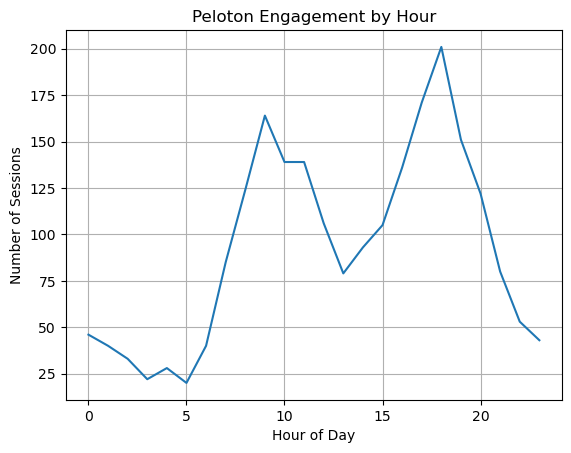

In [5]:
engagement_data = simulate_engagement_data()

In [9]:
from openai import OpenAI
from typing import TypedDict, List, Dict, Any
from geopy.distance import geodesic
from datetime import datetime
from tqdm import tqdm
import time

# === Agent Setup ===
client = OpenAI()

# === Location Reference ===
LOCATION_COORDS = {
    "New York": (40.7128, -74.0060),
    "Paris": (48.8566, 2.3522),
    "San Francisco": (37.7749, -122.4194),
    "Chicago": (41.8781, -87.6298),
    "London": (51.5074, -0.1278)
}

# === WorkoutState Structure ===
class WorkoutState(TypedDict):
    agent_type: str
    goals: List[str]
    recent_workouts: List[str]
    output: str
    login_events: List[Dict[str, Any]]

# === Agent Logic ===
def fraud_agent_node(state: WorkoutState) -> WorkoutState:
    login_events = state.get("login_events", [])

    if len(login_events) < 2:
        return {**state, "output": "Not enough login events to analyze travel patterns."}

    login_text = ""
    for e in login_events:
        login_text += f"Time: {e['timestamp']}, IP: {e['ip']}, Location: {e['location']}\n"

    travel_notes = []
    for i in tqdm(range(1, len(login_events)), desc="Analyzing login transitions..."):
        loc1 = login_events[i - 1]["location"]
        loc2 = login_events[i]["location"]
        time1 = datetime.fromisoformat(login_events[i - 1]["timestamp"].replace("Z", "+00:00"))
        time2 = datetime.fromisoformat(login_events[i]["timestamp"].replace("Z", "+00:00"))

        if loc1 in LOCATION_COORDS and loc2 in LOCATION_COORDS:
            distance_km = geodesic(LOCATION_COORDS[loc1], LOCATION_COORDS[loc2]).kilometers
            duration_hr = (time2 - time1).total_seconds() / 3600
            speed_kph = distance_km / duration_hr if duration_hr > 0 else float("inf")
            travel_notes.append(
                f"Travel from {loc1} to {loc2} covers {distance_km:.1f} km in {duration_hr:.2f} hours (~{speed_kph:.1f} km/h)."
            )
        else:
            travel_notes.append(f"Skipping distance calculation between {loc1} and {loc2} (location not found).")

        time.sleep(0.3)

    full_prompt = (
        f"The following login events occurred:\n{login_text}\n"
        f"Travel observations:\n" + "\n".join(travel_notes) + "\n\n"
        "As a security AI, identify any suspicious travel patterns or anomalies that suggest fraud. "
        "Estimate a confidence score (0-100%) for whether this is fraudulent activity, and explain your reasoning."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a cybersecurity assistant reviewing login activity for fraud detection."},
                {"role": "user", "content": full_prompt}
            ],
            temperature=0.3,
            max_tokens=350
        )
        result = response.choices[0].message.content
    except Exception as e:
        result = f"Error during fraud analysis: {str(e)}"

    return {**state, "output": result}

# === Agent Router ===
def route_agent(state: WorkoutState) -> WorkoutState:
    if state["agent_type"] == "fraud":
        return fraud_agent_node(state)
    else:
        return {**state, "output": "Unsupported agent type."}

# === 3 User Stories for Fraud Agent ===

fraud_tests = [
    {
        "agent_type": "fraud",
        "goals": [],
        "recent_workouts": [],
        "output": "",
        "login_events": [
            {"timestamp": "2024-04-01T02:15:00Z", "ip": "192.168.1.1", "location": "New York"},
            {"timestamp": "2024-04-01T02:18:00Z", "ip": "203.0.113.5", "location": "Paris"},
            {"timestamp": "2024-04-01T08:20:00Z", "ip": "198.51.100.23", "location": "San Francisco"}
        ]
    },
    {
        "agent_type": "fraud",
        "goals": [],
        "recent_workouts": [],
        "output": "",
        "login_events": [
            {"timestamp": "2024-05-02T14:00:00Z", "ip": "10.0.0.1", "location": "Chicago"},
            {"timestamp": "2024-05-02T14:10:00Z", "ip": "10.0.0.2", "location": "New York"},
            {"timestamp": "2024-05-02T14:45:00Z", "ip": "10.0.0.3", "location": "London"}
        ]
    },
    {
        "agent_type": "fraud",
        "goals": [],
        "recent_workouts": [],
        "output": "",
        "login_events": [
            {"timestamp": "2024-06-01T08:00:00Z", "ip": "8.8.8.8", "location": "San Francisco"},
            {"timestamp": "2024-06-01T13:00:00Z", "ip": "8.8.4.4", "location": "San Francisco"},
            {"timestamp": "2024-06-01T17:30:00Z", "ip": "8.8.7.7", "location": "San Francisco"}
        ]
    }
]

# === Test All Stories ===
for i, test_case in enumerate(fraud_tests, 1):
    print(f"\n--- Fraud Agent Test {i} ---")
    result = route_agent(test_case)
    print(result["output"])


--- Fraud Agent Test 1 ---


Analyzing login transitions...: 100%|█████████████| 2/2 [00:00<00:00,  3.28it/s]
2025-06-05 14:03:07,102 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The login events you provided show a rapid sequence of logins from geographically distant locations, which raises potential concerns about account security. Let's analyze the travel patterns:

1. **New York to Paris:**
   - Distance: 5852.9 km
   - Time: 3 minutes (0.05 hours)
   - Speed: ~117,058.7 km/h

2. **Paris to San Francisco:**
   - Distance: 8976.2 km
   - Time: 6.03 hours
   - Speed: ~1,487.8 km/h

**Analysis:**

- **New York to Paris:** The speed required to travel from New York to Paris in 3 minutes is physically impossible with current technology. Commercial flights take approximately 7-8 hours for this route. This suggests that the login from Paris is highly suspicious.

- **Paris to San Francisco:** While the speed of travel here (1,487.8 km/h) is not as extreme as the first leg, it is still faster than any commercial flight, which typically takes about 11 hours. This discrepancy further suggests suspicious activity.

**Confidence Score for Fraudulent Activity: 95%**

**

Analyzing login transitions...: 100%|█████████████| 2/2 [00:00<00:00,  3.29it/s]
2025-06-05 14:03:15,582 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The login events indicate a rapid sequence of logins from geographically distant locations, which is highly suspicious and suggests potential fraudulent activity. Here's the analysis:

1. **Chicago to New York:**
   - Distance: 1147.2 km
   - Time: 10 minutes (0.17 hours)
   - Speed: ~6883.1 km/h

2. **New York to London:**
   - Distance: 5585.2 km
   - Time: 35 minutes (0.58 hours)
   - Speed: ~9574.7 km/h

**Analysis:**

- **Impossibly Fast Travel:** Both travel speeds are far beyond the capabilities of commercial or even military aircraft. The fastest commercial aircraft, such as the Concorde, had a maximum speed of around 2179 km/h. Current commercial flights are even slower, typically cruising around 900 km/h.
  
- **Time Zones and Logins:** The logins occur in quick succession, with the second login happening just 10 minutes after the first, and the third 35 minutes after the second. This rapid sequence across such vast distances is not feasible for a human traveler.

- **IP Addr

Analyzing login transitions...: 100%|█████████████| 2/2 [00:00<00:00,  3.27it/s]
2025-06-05 14:03:24,389 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Based on the login events and travel observations provided, here is an analysis of the situation:

1. **Login Events:**
   - All login events occurred from IP addresses that are associated with San Francisco.
   - The time intervals between the logins are:
     - 5 hours between the first and second login.
     - 4.5 hours between the second and third login.

2. **Travel Observations:**
   - The travel analysis indicates that the user is consistently logging in from the same location (San Francisco), with no actual physical travel involved.

3. **Analysis:**
   - There is no indication of unusual travel patterns, such as logging in from geographically distant locations within a short time frame, which would typically suggest account compromise or fraudulent activity.
   - The IP addresses used are different but still resolve to the same general location (San Francisco). This could be due to the user connecting through different networks or ISPs, which is common and not inherently suspi

In [11]:
from typing import TypedDict, List
from openai import OpenAI
from tqdm import tqdm
import time

# Define state structure
class WorkoutState(TypedDict):
    agent_type: str
    goals: List[str]
    recent_workouts: List[str]
    output: str

# Initialize OpenAI client
client = OpenAI()

# Product Recommendation Agent
def product_agent_node(state: WorkoutState) -> WorkoutState:
    goals = state.get("goals", [])
    recent_workouts = state.get("recent_workouts", [])

    if not goals or not recent_workouts:
        return {**state, "output": "Insufficient data for personalized recommendation."}

    profile_str = (
        "User Fitness Goals: " + ", ".join(goals) + "\n"
        "Recent Workouts: " + ", ".join(recent_workouts)
    )

    for _ in tqdm(range(3), desc="Generating personalized Peloton workout..."):
        time.sleep(0.3)

    system_prompt = (
        "You are a Peloton fitness assistant. Always recommend a real, specific Peloton workout class "
        "or program, including the class type (e.g., 'Power Zone Ride', 'HIIT Cardio', 'Full Body Bootcamp'), "
        "and if possible, suggest a real Peloton instructor. Make your answer motivating and explain your choice."
    )
    user_prompt = (
        f"Here is the user's profile:\n{profile_str}\n\n"
        "Recommend their next Peloton class, using real class names or types."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.4,
            max_tokens=350
        )
        result = response.choices[0].message.content
    except Exception as e:
        result = f"Error during recommendation: {str(e)}"

    return {**state, "output": result}

# --- 3 Test User Stories ---

# Test 1: Strength goals
test_input_1: WorkoutState = {
    "agent_type": "product",
    "goals": ["muscle gain", "strength training"],
    "recent_workouts": ["Full Body Strength", "Upper Body Dumbbell Burn", "Core Conditioning"],
    "output": ""
}

# Test 2: Cardio goals
test_input_2: WorkoutState = {
    "agent_type": "product",
    "goals": ["fat loss", "cardio endurance"],
    "recent_workouts": ["HIIT Cardio", "Outdoor Run", "30-min Tread Bootcamp"],
    "output": ""
}

# Test 3: Recovery and flexibility
test_input_3: WorkoutState = {
    "agent_type": "product",
    "goals": ["flexibility", "stress relief"],
    "recent_workouts": ["Evening Yoga Flow", "Guided Meditation", "Lower Body Stretch"],
    "output": ""
}

# Run all 3
for i, test_input in enumerate([test_input_1, test_input_2, test_input_3], 1):
    print(f"\n--- Product Agent Test {i} ---")
    output_state = product_agent_node(test_input)
    print(output_state["output"])


--- Product Agent Test 1 ---


Generating personalized Peloton workout...: 100%|█| 3/3 [00:00<00:00,  3.30it/s]
2025-06-05 14:04:34,538 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To continue on your path to muscle gain and strength training, I recommend trying the "Full Body Strength" class with Adrian Williams. Adrian is known for his motivating energy and focus on form, which will help you maximize your strength gains. This class will challenge you with compound movements that target multiple muscle groups, ensuring you get a comprehensive workout that builds strength and muscle effectively. Keep pushing your limits and remember, every rep counts towards your goal!

--- Product Agent Test 2 ---


Generating personalized Peloton workout...: 100%|█| 3/3 [00:00<00:00,  3.28it/s]
2025-06-05 14:04:37,717 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To keep you on track with your fat loss and cardio endurance goals, I recommend trying the "30-Minute HIIT and Hills Ride" with instructor Robin Arzón. This class is perfect for torching calories and building cardiovascular strength, as it combines high-intensity intervals with challenging hill climbs. Robin's energy is infectious, and she'll motivate you to push through those tough moments. This workout will not only help you burn fat but also improve your endurance, making it a great complement to your recent HIIT Cardio and Tread Bootcamp sessions. Keep up the great work, and enjoy the ride!

--- Product Agent Test 3 ---


Generating personalized Peloton workout...: 100%|█| 3/3 [00:00<00:00,  3.28it/s]
2025-06-05 14:04:40,998 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Based on your fitness goals of flexibility and stress relief, I recommend trying the "Restorative Yoga" class with Kristin McGee. This class type is designed to help you unwind, release tension, and improve flexibility through gentle, supported poses that allow your body to relax deeply. Kristin McGee's soothing guidance will help you focus on your breath and find tranquility, making it a perfect choice for stress relief. This class will complement your recent workouts and help you achieve a balanced and peaceful state of mind. Keep up the great work on your journey to wellness!


In [13]:
from openai import OpenAI
from typing import TypedDict, List, Dict, Any
from tqdm import tqdm
import pandas as pd
import time

# Shared State
class WorkoutState(TypedDict, total=False):
    agent_type: str
    goals: List[str]
    recent_workouts: List[str]
    output: str
    login_events: List[Dict[str, Any]]
    engagement_data: List[Dict[str, Any]]
    ds_task: str  # used by Data Science agent

client = OpenAI()

def data_science_agent_node(state: WorkoutState) -> WorkoutState:
    ds_task = state.get("ds_task", "summarize")
    engagement_data = state.get("engagement_data")
    output = ""
    
    for _ in tqdm(range(3), desc=f"Running Data Science Task: {ds_task}"):
        time.sleep(0.3)

    if not engagement_data:
        return {**state, "output": "No engagement data provided."}
    
    df = pd.DataFrame(engagement_data)
    data_string = df[['hour', 'sessions']].to_string(index=False)

    # Task-specific prompts
    if ds_task == "summarize":
        system_prompt = (
            "You are a Peloton data scientist. Summarize the 24-hour session trend. "
            "Highlight peak hours, low periods, and anomalies."
        )
    elif ds_task == "forecast":
        system_prompt = (
            "You are a Peloton data scientist. Forecast session engagement for the next 6 hours "
            "based on the provided 24-hour session trend. Explain your forecast."
        )
    elif ds_task == "cohort":
        system_prompt = (
            "You are a Peloton data scientist. Analyze the engagement data for signs of cohort behavior—"
            "for example, users who always attend at the same time, or engagement spikes tied to certain patterns."
        )
    else:
        return {**state, "output": f"Unknown ds_task: {ds_task}"}
    
    user_prompt = f"Here is the 24-hour engagement data:\n{data_string}"

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.35,
            max_tokens=400
        )
        output = response.choices[0].message.content
    except Exception as e:
        output = f"Error during data science analysis: {str(e)}"
    
    return {**state, "output": output}

# --- Example Test for All 3 User Stories ---
engagement_data = [
    {"hour": i, "sessions": n}
    for i, n in enumerate([
        50, 40, 35, 30, 25, 20, 45, 80, 120, 160, 140, 130,
        110, 90, 85, 100, 140, 180, 200, 150, 120, 80, 60, 40
    ])
]

for ds_task in ["summarize", "forecast", "cohort"]:
    test_input: WorkoutState = {
        "agent_type": "data_science",
        "engagement_data": engagement_data,
        "ds_task": ds_task
    }
    output_state = data_science_agent_node(test_input)
    print(f"\n--- Data Science Agent Output for task: {ds_task} ---\n")
    print(output_state["output"])

Running Data Science Task: summarize: 100%|███████| 3/3 [00:00<00:00,  3.28it/s]
2025-06-05 14:13:19,540 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



--- Data Science Agent Output for task: summarize ---

The 24-hour session trend for Peloton shows distinct patterns in user engagement throughout the day. 

**Peak Hours:**
- The highest engagement occurs at 18:00 (6 PM) with 200 sessions, indicating this is the peak hour when most users are active.
- Other notable high engagement periods include 17:00 (5 PM) with 180 sessions and 9:00 (9 AM) with 160 sessions, suggesting these are also popular times for users.

**Low Periods:**
- The lowest engagement is observed in the early morning hours, particularly at 5:00 (5 AM) with only 20 sessions.
- Other low periods include 4:00 (4 AM) with 25 sessions and 3:00 (3 AM) with 30 sessions, indicating minimal activity during these hours.

**Anomalies:**
- There is a noticeable increase in sessions starting at 6:00 (6 AM) with 45 sessions, which then sharply rises to 80 sessions at 7:00 (7 AM), suggesting a morning workout trend.
- A significant drop in sessions is seen after the peak at 18:00 

Running Data Science Task: forecast: 100%|████████| 3/3 [00:00<00:00,  3.28it/s]
2025-06-05 14:13:27,924 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



--- Data Science Agent Output for task: forecast ---

To forecast session engagement for the next 6 hours, we can analyze the provided 24-hour session trend to identify patterns and trends that might influence future engagement.

### Observations from the Data:
1. **Early Morning Decline (0-5 hours):** There is a steady decline in sessions from midnight (50 sessions) to 5 AM (20 sessions). This is likely due to people sleeping or not engaging in workouts during these hours.
   
2. **Morning Surge (6-9 hours):** There is a significant increase in sessions starting at 6 AM (45 sessions) peaking at 9 AM (160 sessions). This is typical as people often exercise before starting their day.

3. **Midday Decline (10-14 hours):** After the morning peak, there is a gradual decline in sessions from 10 AM (140 sessions) to 2 PM (85 sessions). This suggests people are less engaged during typical work or school hours.

4. **Afternoon Recovery (15-18 hours):** Engagement picks up again in the afterno

Running Data Science Task: cohort: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
2025-06-05 14:13:38,415 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



--- Data Science Agent Output for task: cohort ---

To analyze the engagement data for signs of cohort behavior and engagement spikes, let's break down the data and look for patterns:

1. **Peak Engagement Hours**:
   - The highest engagement occurs at 18:00 (6 PM) with 200 sessions. This indicates a significant spike, likely due to users finishing their workday and engaging in workouts.
   - Other high engagement periods include 17:00 (5 PM) with 180 sessions and 9:00 (9 AM) with 160 sessions. These times could correspond to people starting their day with a workout or taking a break during work hours.

2. **Morning Engagement**:
   - There is a noticeable increase in sessions starting from 6:00 (6 AM) with 45 sessions, peaking at 9:00 (9 AM). This suggests a cohort of users who prefer morning workouts, possibly before starting their day.

3. **Afternoon Engagement**:
   - Engagement remains relatively high from 10:00 (10 AM) to 16:00 (4 PM), with a slight dip at 13:00 (1 PM). This co

In [19]:
from openai import OpenAI
from typing import TypedDict, List, Dict, Any, Optional
from tqdm import tqdm
import time
import pandas as pd

# Define state
class WorkoutState(TypedDict, total=False):
    agent_type: str
    goals: List[str]
    recent_workouts: List[str]
    output: str
    engagement_data: List[Dict[str, Any]]  # e.g. [{hour: 9, sessions: 120}, ...]
    marketing_style: str  # "email", "social", "in-app"

client = OpenAI()

def marketing_agent_node(state: WorkoutState) -> WorkoutState:
    goals = state.get("goals", [])
    engagement_data = state.get("engagement_data", [])
    marketing_style = state.get("marketing_style", "email")

    # Build engagement summary
    engagement_summary = ""
    if engagement_data:
        df = pd.DataFrame(engagement_data)
        peak_hour = int(df.loc[df['sessions'].idxmax(), 'hour'])
        avg_sessions = df['sessions'].mean()
        engagement_summary = f"Peak engagement hour is {peak_hour}:00 with an average of {avg_sessions:.1f} sessions per hour."
    else:
        engagement_summary = "No engagement data provided."

    profile_str = (
        "User Fitness Goals: " + ", ".join(goals) + "\n"
        f"Engagement Summary: {engagement_summary}"
    )

    for _ in tqdm(range(3), desc="Generating marketing message..."):
        time.sleep(0.3)

    system_prompt = (
        "You are a Peloton marketing strategist. Create a motivating, persuasive message tailored to the user’s fitness goals and engagement habits. "
        "Write in the requested style (email, social post, or in-app message). Always use an encouraging tone and include a subtle call-to-action. "
        "Do not use emojis."
    )
    user_prompt = (
        f"User profile:\n{profile_str}\n\n"
        f"Marketing channel: {marketing_style}. Write a message in this format."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.5,
            max_tokens=300
        )
        result = response.choices[0].message.content
    except Exception as e:
        result = f"Error during marketing message generation: {str(e)}"

    return {**state, "output": result}

# Simulate engagement data
engagement_data = [
    {"hour": i, "sessions": n}
    for i, n in enumerate([
        40, 35, 30, 25, 20, 15, 50, 90, 130, 170, 150, 140,
        120, 100, 90, 110, 150, 190, 210, 160, 130, 90, 65, 45
    ])
]

test_input: WorkoutState = {
    "agent_type": "marketing",
    "goals": ["endurance", "weight loss"],
    "engagement_data": engagement_data,
    "marketing_style": "email",
    "output": ""
}

for i in range(3):
    print(f"\n--- Marketing Agent Output {i+1} ---")
    output_state = marketing_agent_node(test_input)
    print(output_state["output"])


--- Marketing Agent Output 1 ---


Generating marketing message...: 100%|████████████| 3/3 [00:00<00:00,  3.27it/s]
2025-06-05 14:19:57,238 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Subject: Unlock Your Potential: Evening Rides Await!

Hi [User's Name],

We hope this message finds you energized and ready to conquer your fitness journey! We've noticed your dedication and commitment during your peak workout time at 18:00. You're truly inspiring, and we're here to help you push even further.

Your goals of enhancing endurance and shedding those extra pounds are within reach, and our specially curated evening rides are designed to help you achieve just that. These sessions are tailored to keep your heart rate up and your motivation high, ensuring you stay on track with your fitness aspirations.

Why not make tonight's session a transformative one? Our expert instructors are ready to guide you through invigorating rides that challenge your limits and celebrate your progress.

Remember, every pedal stroke is a step closer to your goals. Keep that momentum going, and let's make every evening ride count!

Looking forward to seeing you on the leaderboard tonight!

Stay Str

Generating marketing message...: 100%|████████████| 3/3 [00:00<00:00,  3.29it/s]
2025-06-05 14:20:03,992 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Subject: Elevate Your Evening Workouts with Peloton

Hi [User's Name],

We hope this message finds you well and ready to conquer your fitness goals. We noticed that your dedication shines brightest around 6 PM, and we want to help you make the most of those evening sessions.

Your commitment to building endurance and achieving weight loss is truly inspiring. With Peloton, you have all the tools you need to take your workouts to the next level. Imagine the feeling of reaching new milestones, one pedal stroke or stride at a time.

To support your journey, we recommend exploring our specially curated evening classes designed to boost endurance and maximize calorie burn. Whether it's a high-energy cycling session or a challenging run, our instructors are here to guide and motivate you every step of the way.

Ready to push your limits? Log in to your Peloton account and discover the classes that align with your goals. Let's make your 6 PM workouts the highlight of your day.

Keep pushing fo

Generating marketing message...: 100%|████████████| 3/3 [00:00<00:00,  3.29it/s]
2025-06-05 14:20:11,952 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Subject: Unlock Your Peak Performance at 6 PM!

Hi [User's Name],

We hope this message finds you well and ready to conquer your fitness goals! At Peloton, we understand that endurance and weight loss are at the top of your list, and we're here to support you every step of the way.

Did you know that your peak performance hour is 6 PM? This is the perfect time to harness your energy and dedication to push your limits. With an impressive average of 98.1 sessions per hour, you're already on the path to success. Imagine what you can achieve by consistently dedicating this time to your fitness journey!

To help you stay motivated, we've curated a selection of endurance-focused and weight-loss rides specifically designed to maximize your results. Whether you're looking to build stamina or shed those extra pounds, there's a class tailored just for you.

Why not make 6 PM your power hour? Commit to your goals and see the transformation unfold. Visit your Peloton app to explore our latest clas

In [23]:
from openai import OpenAI
from typing import TypedDict, List, Dict, Any, Optional
from tqdm import tqdm
import time
import pandas as pd

# Define state
class WorkoutState(TypedDict, total=False):
    agent_type: str
    shipping_task: str  # "analyze", "flag_delays", "optimize"
    output: str
    shipping_events: List[Dict[str, Any]]  # Must include order_id, ship_time, delivery_time, status

client = OpenAI()

def shipping_agent_node(state: WorkoutState) -> WorkoutState:
    task = state.get("shipping_task", "analyze")
    shipping_data = state.get("shipping_events", [])

    if not shipping_data:
        return {**state, "output": "No shipping data provided."}

    df = pd.DataFrame(shipping_data)
    sample_orders = df[['order_id', 'ship_time', 'delivery_time', 'status']].to_string(index=False)

    for _ in tqdm(range(3), desc=f"Running Shipping Task: {task}"):
        time.sleep(0.3)

    if task == "flag_delays":
        system_prompt = (
            "You are a shipping logistics analyst. Examine the data for excessive shipping delays "
            "or failed deliveries. Identify orders that might require intervention or follow-up."
        )
    elif task == "analyze":
        system_prompt = (
            "You are a shipping logistics analyst. Analyze the shipping event data to identify "
            "patterns in delays, bottlenecks, or performance trends across the orders."
        )
    elif task == "optimize":
        system_prompt = (
            "You are a shipping operations expert. Review the data and suggest concrete ways to reduce shipping times, "
            "improve delivery reliability, or enhance operational efficiency."
        )
    else:
        return {**state, "output": f"Unknown shipping task: {task}"}

    user_prompt = f"Here is the recent shipping data:\n{sample_orders}"

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.4,
            max_tokens=500
        )
        result = response.choices[0].message.content
    except Exception as e:
        result = f"Error during shipping analysis: {str(e)}"

    return {**state, "output": result}

# Simulated shipping event data
shipping_events = [
    {"order_id": "A001", "ship_time": "2025-06-01 10:00", "delivery_time": "2025-06-03 12:30", "status": "Delivered"},
    {"order_id": "A002", "ship_time": "2025-06-01 11:00", "delivery_time": "2025-06-05 09:00", "status": "Delivered"},
    {"order_id": "A003", "ship_time": "2025-06-02 09:00", "delivery_time": "", "status": "In Transit"},
    {"order_id": "A004", "ship_time": "2025-06-01 15:00", "delivery_time": "2025-06-04 14:00", "status": "Delayed"},
]

# Run the shipping agent for 3 task variants
for shipping_task in ["flag_delays", "analyze", "optimize"]:
    test_input: WorkoutState = {
        "agent_type": "shipping",
        "shipping_task": shipping_task,
        "shipping_events": shipping_events,
        "output": ""
    }
    output_state = shipping_agent_node(test_input)
    print(f"\n--- Shipping Agent Output: {shipping_task} ---\n")
    print(output_state["output"])

Running Shipping Task: flag_delays: 100%|█████████| 3/3 [00:00<00:00,  3.27it/s]
2025-06-05 14:31:03,563 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



--- Shipping Agent Output: flag_delays ---

Based on the shipping data provided, here are the orders that might require intervention or follow-up:

1. **Order A003**: 
   - Current Status: In Transit
   - Ship Time: 2025-06-02 09:00
   - No delivery time recorded.
   - Since today's date is not provided, if this order has been in transit for a significantly long time without an update, it might require follow-up to ensure it is not lost or excessively delayed.

2. **Order A004**:
   - Current Status: Delayed
   - Ship Time: 2025-06-01 15:00
   - Delivery Time: 2025-06-04 14:00
   - This order was marked as delayed. It would be prudent to investigate the reason for the delay and ensure that similar delays do not occur in the future.

For both orders, follow-up with the shipping carrier to get updates or resolve any underlying issues would be advisable.


Running Shipping Task: analyze: 100%|█████████████| 3/3 [00:00<00:00,  3.29it/s]
2025-06-05 14:31:17,428 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



--- Shipping Agent Output: analyze ---

To analyze the shipping event data and identify patterns in delays, bottlenecks, or performance trends, let's break down the information provided:

1. **Order A001:**
   - Ship Time: 2025-06-01 10:00
   - Delivery Time: 2025-06-03 12:30
   - Status: Delivered
   - Delivery Duration: Approximately 2 days and 2.5 hours.

2. **Order A002:**
   - Ship Time: 2025-06-01 11:00
   - Delivery Time: 2025-06-05 09:00
   - Status: Delivered
   - Delivery Duration: Approximately 3 days and 22 hours.

3. **Order A003:**
   - Ship Time: 2025-06-02 09:00
   - Delivery Time: Not provided
   - Status: In Transit
   - Current Duration In Transit: As of the last update, it's been in transit for more than 1 day.

4. **Order A004:**
   - Ship Time: 2025-06-01 15:00
   - Delivery Time: 2025-06-04 14:00
   - Status: Delayed
   - Delivery Duration: Approximately 2 days and 23 hours.

### Analysis:

- **Average Delivery Time:**
  - For delivered orders (A001 and A002), t

Running Shipping Task: optimize: 100%|████████████| 3/3 [00:00<00:00,  3.28it/s]
2025-06-05 14:31:28,806 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



--- Shipping Agent Output: optimize ---

Based on the shipping data provided, here are some suggestions to reduce shipping times, improve delivery reliability, and enhance operational efficiency:

1. **Analyze Delays and In-Transit Orders:**
   - **Order A004** was delayed, and **Order A003** is still in transit. Investigate the reasons for the delay and the prolonged transit time. Common issues could be related to logistics, such as warehouse processing delays, carrier issues, or route inefficiencies. Address these issues by optimizing warehouse operations or collaborating closely with carriers to ensure timely pickups and deliveries.

2. **Optimize Shipping Schedules:**
   - Consider the shipping and delivery times for **Order A002**, which took longer than **Order A001** despite being shipped on the same day. Analyze the routes and carriers used for these shipments. Implement route optimization software to ensure the most efficient paths are taken and consider using multiple carrie